In [0]:
import pandas as pd
import seaborn as sns
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
sys.path.append('/usr/local/lib/python3.6/site-packages')
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

In [0]:
#import data
df = pd.read_csv("/home/stolan/Documents/ec/DecMaking/dat/reincidenciaJusticiaMenors.csv",low_memory=False)
df.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [0]:
## Main crime of first recidivism: start in 2010 until 2013
##df.V117_rein_data_fet_2013 

## Date of first recidivism: start in 2010 until 2015
##df.V101_rein_data_fet_2015.value_counts() #I think this is the same as V117 but measured in 2015

##Try to get the timeframe of this data
##date of main crime
[np.min(df.V22_data_fet), np.max(df.V22_data_fet)]

['01-Apr-2005', '31-Oct-2009']

This suggests, that crimes were committed between April 2005 and October 2009.
Then, there were two follow ups, one in 2013 and the other in 2015 about recidivism status.

In [0]:
#df['V56_@R1_resum_risc_global_reverse'].isnull().sum() #3895
#df['V57_@R2_resum_risc_delictes_violents'].isnull().sum() #4396
#df['V58_@R3_resum_risc_violencia_centre'].isnull().sum() #4622
#df['V59_@R4_resum_risc_sortides_permisos'].isnull().sum() #4617
#df['V60_SAVRY_total_score'].isnull().sum() #3895
#print(df[['V56_@R1_resum_risc_global_reverse','V60_SAVRY_total_score']]) ##These two columns do not correspond
#df['V60_SAVRY_total_score'].loc[df.V60_SAVRY_total_score==99.0].sum()/99
#df.V60_SAVRY_total_score.value_counts()


In [0]:
##1. Aequitas data Score = SAVRRY total score

df = df.rename(index=str, columns={"V2_estranger": "foreigner", "V1_sexe": "sex","V60_SAVRY_total_score": "full_score", \
                                  "V115_reincidencia_2015":'recid', "V4_nacionalitat_agrupat":"national_group", \
                                  "V5_edat_fet_agrupat":"age_group","V6_provincia":"province","V9_edat_final_programa": \
                                  "age_final", "V11_antecedents":"prior_crime", "V12_nombre_ante_agrupat": \
                                   "prior_crimerec","V13_nombre_fets_agrupat": "prior_crimes", "V15_fet_agrupat": \
                                  "crime_maincat", "V16_fet_violencia": "crime_violence", "V17_fet_tipus":"crime_type" \
                                  })
df['label_value'] = df.recid == 'Sí'
dfaequi=df[['id','label_value','full_score','foreigner','sex','national_group','age_group','province','age_final', \
            'prior_crime','prior_crimerec','prior_crimes','crime_maincat','crime_violence', 'crime_type' ]]


dfaequi = dfaequi[np.isfinite(dfaequi['full_score'])]
dfaequi = dfaequi.loc[dfaequi['full_score']!=99]
df = dfaequi
del dfaequi

##Value counts
N=len(df)
df.sex.value_counts() #747 male, 108 female
df['male'] = df['sex'] == 'Home'
df.foreigner.value_counts() #524 spanish, 331 foreigner
df['spanish'] = df['foreigner'] == 'Espanyol'
N_sexm = df.loc[df.male==1].sum()
N_sexf = df.loc[df.male==0].sum()
N_foreign0 = df.loc[df.spanish==1].sum()
N_foreign1 = df.loc[df.spanish==0].sum()
df.head()

,id,label_value,full_score,foreigner,sex,national_group,age_group,province,age_final,prior_crime,prior_crimerec,prior_crimes,crime_maincat,crime_violence,crime_type,male,spanish
0,691,True,30.0,Espanyol,Home,NaN,14 i 15 anys,Lleida,17,Amb antecedents,1 o 2 antecedents,3 fets o més,Contra les persones,Violent,Delicte,True,True
1,956,True,27.0,Espanyol,Dona,NaN,14 i 15 anys,Barcelona,15,Amb antecedents,1 o 2 antecedents,2 fets,Contra les persones,Violent,Delicte,False,True
2,2560,True,26.0,Estranger,Home,Magrib,14 i 15 anys,Barcelona,16,Amb antecedents,De 3 a 5 antecedents,3 fets o més,Contra les persones,Violent,Delicte,True,False
3,2018,True,35.0,Estranger,Home,Magrib,14 i 15 anys,Girona,15,Amb antecedents,Més de 5 antecedents,2 fets,Contra les persones,Violent,Delicte,True,False
4,1650,True,31.0,Espanyol,Home,NaN,16 i 17 anys,Tarragona,20,Amb antecedents,Més de 5 antecedents,3 fets o més,Contra les persones,Violent,Delicte,True,True


This is the first specification of the current analysis. The SAVRY score yields information for 855 individuals of which 747 are male and 108 are female. Of these 855, 524 are spanish and 331 are foreign. The label indicates whether the person, wo committed a crime between 2005 and 2009, recidiviated any time between 2010 and 2015. I use as risk score the "SAVRY" total sum of risk of 24 risk scores (TSS). Each indicator is either 0 for low, 1 for intermediate and 2 for high. Thus, the maximum possible TSS is 48 but in this sample the maximum TSS is 40. I do some short exploratory analysis based on the full distribution of the risk score but then classify into a binary indicator which is 0, i.e. low if the TSS is below 20 and 1 if the TSS is greater than or equal to 20. I conduct some fairness analysis for sex and nationality status (i.e. foreign, not foreign)

In [0]:
#Reduce score to a binary variable
df['score']=df['full_score']>=20
df.score.value_counts()

False    576
True     279
Name: score, dtype: int64

The overall recidivism rate is 33% for the total SAVRY sample

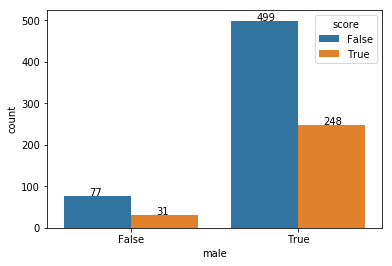

In [0]:
###Exploratory analysis
#as in the aequitas tutorial
ax = sns.countplot(x="male", hue="score", data=df)
total = float(len(df)) # one person per row 

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

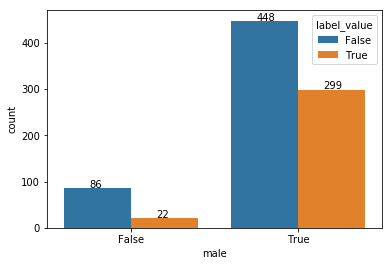

In [0]:
ax = sns.countplot(x="male", hue="label_value", data=df)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

The distribution of a high SAVRY risk scores across sex (28% for females and 33% for males) compared to the distribution of recidivism base rates across sex (20% for females and 40% for males) suggests that recidivism risk for females might be overpredicted while being underpredicted for males. This follows the own definition of a high TSS. Repeat this analysis with the variable "V56_@R1_resum_risc_global_reverse". This variable deviates from the TSS. Q: How do these two labels correspond? 

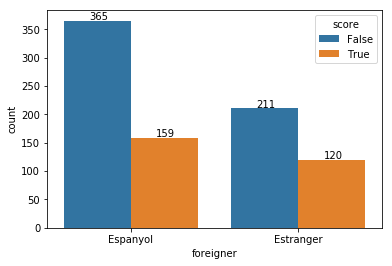

In [0]:
#Distribution of risk scores foreign / not foreign
ax = sns.countplot(x="foreigner", hue="score", data=df)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

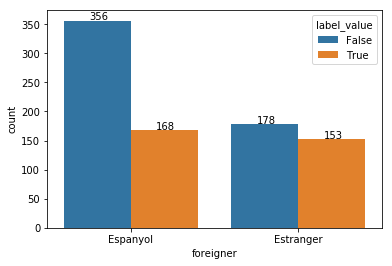

In [0]:
#Distribution of label_value foreign, not foreign
ax = sns.countplot(x="foreigner", hue="label_value", data=df)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [0]:
list(df)

['id',
 'label_value',
 'full_score',
 'foreigner',
 'sex',
 'national_group',
 'age_group',
 'province',
 'age_final',
 'prior_crime',
 'prior_crimerec',
 'prior_crimes',
 'crime_maincat',
 'crime_violence',
 'crime_type',
 'male',
 'spanish',
 'score']

In [0]:
##drop variables that do not work with t

The distribution of a high TSS across nationality (foreign/spanish) (30% for spanish and 36% for foreigners) compared to the distribution of recidivism base rates across nationality (32% for spanish and 46% for foreigners) suggests that recidivism risk for foreigners might be underpredicted. Repeat this analysis with the variable "V56_@R1_resum_risc_global_reverse". This variable deviates from the TSS. Q: How do these two labels correspond? 

In [0]:
#Prepare data for Aequias
##set every attribute column to category type
obj_df["body_style"] = obj_df["body_style"].astype('category')
obj_df.dtypes

In [0]:
del df2

In [0]:
###Run Aequitas-Analysis
#first: with binary score variable

g = Group()
xtab, _ = g.get_crosstabs(df)

ERROR:root:get_crosstabs: input df was not preprocessed. There are non-string cols within attr_cols!


NameError: name 'exit' is not defined